# Importation des bibliothèques

In [1]:
import re
import os
import time
import kagglehub
import keras
import matplotlib.pyplot as plt
import numpy as np
import keras_hub
import keras_tuner
import pandas as pd
import pkuseg
import tensorflow as tf
from datasets import Dataset
from pypinyin import lazy_pinyin
from keras.layers import (
    LSTM,
    Dense,
    Embedding,
    Input,
    Dropout,
    Concatenate,
    Attention,
    StringLookup,
    TextVectorization,
)
from keras.models import Model
import pickle as pk

# Vérifier GPU
print(tf.config.list_physical_devices('GPU'))
# tf.debugging.set_log_device_placement(True)

seg = pkuseg.pkuseg()
path = kagglehub.dataset_download("noxmoon/chinese-official-daily-news-since-2016")

print("\nPath to dataset files:", path)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

Path to dataset files: /Users/petx/.cache/kagglehub/datasets/noxmoon/chinese-official-daily-news-since-2016/versions/1


# Création du corpus

In [2]:
dataset = pd.read_csv(path+"/chinese_news.csv")
# Print dataset information
print("Dataset information:")
print(dataset.info())
# Print dataset head
print("Dataset head:")
print(dataset.head())

Dataset information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20738 entries, 0 to 20737
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   date      20738 non-null  object
 1   tag       20738 non-null  object
 2   headline  20738 non-null  object
 3   content   20631 non-null  object
dtypes: object(4)
memory usage: 648.2+ KB
None
Dataset head:
         date   tag                                           headline  \
0  2016-01-01  详细全文  陆军领导机构火箭军战略支援部队成立大会在京举行 习近平向中国人民解放军陆军火箭军战略支援部队...   
1  2016-01-01  详细全文                             中央军委印发《关于深化国防和军队改革的意见》   
2  2016-01-01  详细全文                           《习近平关于严明党的纪律和规矩论述摘编》出版发行   
3  2016-01-01  详细全文                                 以实际行动向党中央看齐 向高标准努力   
4  2016-01-01  详细全文                                 【年终特稿】关键之年 改革挺进深水区   

                                             content  
0  中国人民解放军陆军领导机构、中国人民解放军火箭军、中国人民解放军战略支援部队成立大会2015...  
1  经中央军委主席习近平批准，中央军委近日印发了《关

In [3]:
# Prétraitement de content (suppression des caractères non chinois, normalisation des espaces)
def clean_content(text):
    if not isinstance(text, str):
        return ""
    
    # Garder les caractères chinois et ponctuation chinoise
    text = re.sub(r"[^\u4e00-\u9fff\u3000-\u303F\uff00-\uffef]", "", text)
    
    # Normaliser les espaces (rare, mais au cas où)
    text = text.replace(" ", "").strip()

    return text

# Remplacer les valeurs manquantes par une chaîne vide
dataset["content"] = dataset["content"].fillna("")

# Appliquer le prétraitement à la colonne 'content'
dataset['cleaned_content'] = dataset['content'].apply(clean_content)

# Filtrer les lignes où 'cleaned_content' est vide
dataset = dataset[dataset["cleaned_content"].str.strip() != ""].reset_index(drop=True)

# Afficher les 5 premières lignes du DataFrame après le prétraitement
print("Dataset after preprocessing:")
print(dataset[['content', 'cleaned_content']].head())


dataset["tokens"] = dataset["cleaned_content"].apply(lambda x: seg.cut(x))

# Aperçu
print(dataset["tokens"].head())

Dataset after preprocessing:
                                             content  \
0  中国人民解放军陆军领导机构、中国人民解放军火箭军、中国人民解放军战略支援部队成立大会2015...   
1  经中央军委主席习近平批准，中央军委近日印发了《关于深化国防和军队改革的意见》。\n《意见》强...   
2  由中共中央纪律检查委员会、中共中央文献研究室编辑的《习近平关于严明党的纪律和规矩论述摘编》一...   
3  广大党员干部正在积极学习习近平总书记在中央政治局专题民主生活会上的重要讲话。大家纷纷表示要把...   
4  刚刚过去的2015年，是全面深化改革的关键之年。改革集中发力在制约经济社会发展的深层次矛盾，...   

                                     cleaned_content  
0  中国人民解放军陆军领导机构、中国人民解放军火箭军、中国人民解放军战略支援部队成立大会年月日在...  
1  经中央军委主席习近平批准，中央军委近日印发了《关于深化国防和军队改革的意见》。《意见》强调，...  
2  由中共中央纪律检查委员会、中共中央文献研究室编辑的《习近平关于严明党的纪律和规矩论述摘编》一...  
3  广大党员干部正在积极学习习近平总书记在中央政治局专题民主生活会上的重要讲话。大家纷纷表示要把...  
4  刚刚过去的年，是全面深化改革的关键之年。改革集中发力在制约经济社会发展的深层次矛盾，集中发力...  
0    [中国, 人民, 解放军, 陆军, 领导, 机构, 、, 中国, 人民, 解放军, 火箭军,...
1    [经, 中央军委, 主席, 习近平, 批准, ，, 中央军委, 近日, 印发, 了, 《, ...
2    [由, 中共中央, 纪律, 检查, 委员会, 、, 中共中央, 文献, 研究室, 编辑, 的...
3    [广大, 党员, 干部, 正在, 积极, 学习, 习近平, 总书记, 在, 中央, 政治局,...
4    [刚刚, 过去, 的, 年, ，, 是, 全面, 深化, 改革, 的, 关键, 之, 年, ...
Name: tokens, dtype: object


Cette cellule convertit le texte segmenté en séquences combinant chaque caractère chinois, son pinyin (romanisation), et son code T9 correspondant (basé sur un mappage prédéfini). Une fonction `pinyin_to_t9` traduit le pinyin en codes T9, et `generer_sequence_contextuell` crée des triplets (caractère|pinyin|T9) pour chaque mot. Les séquences sont stockées dans une nouvelle colonne et sauvegardées dans un fichier CSV

In [4]:
# convert the content column to pinyin
t9_map = {
    "@": "1", ".": "1", ":": "1",
    "a": "2", "b": "2", "c": "2",
    "d": "3", "e": "3", "f": "3",
    "g": "4", "h": "4", "i": "4",
    "j": "5", "k": "5", "l": "5",
    "m": "6", "n": "6", "o": "6",
    "p": "7", "q": "7", "r": "7", "s": "7",
    "t": "8", "u": "8", "v": "8",
    "w": "9", "x": "9", "y": "9", "z": "9",
    "1": "1", "2": "2", "3": "3", "4": "4",
    "5": "5", "6": "6", "7": "7", "8": "8",
    "9": "9", "0": "0", " ": "0",
    "。":"。", "，":"，", "？":"？", "！":"！",
}

# Fonction pour convertir une chaîne de caractères en code T9
def pinyin_to_t9(text):
    t9_code = ""
    if pd.isna(text):
        return ""
    for char in text.lower():
        t9_code += t9_map.get(char, char)  # Conserver les caractères non mappés
    return t9_code

def validate_t9(t9_code):
    # Vérifie que le code T9 est numérique (ou vide pour ponctuation)
    return bool(re.match(r'^[0-9]+$', t9_code)) or t9_code in {"。", "，", "？", "！"}

def generer_sequence_contextuelle(row):
    tokens = row["tokens"]
    sequence = []
    for token in tokens:
        if not isinstance(token, str) or not re.search(r'[\u4e00-\u9fff]', token):
            continue
        for char, py in zip(token, lazy_pinyin(token)):
            t9 = pinyin_to_t9(py)
            if validate_t9(t9):  # Vérifier que le T9 est valide
                sequence.append(f"{char}|{py}|{t9}")
    return ' '.join(sequence)

dataset["char_pinyin_t9_sequence"] = dataset.apply(generer_sequence_contextuelle, axis=1)

# Filtrer les lignes où 'char_pinyin_t9_sequence' est vide
dataset = dataset[dataset["char_pinyin_t9_sequence"].str.strip() != ""].reset_index(drop=True)

# Sauvegarder le fichier
if not os.path.exists("dataset"):
    os.makedirs("dataset")
dataset[["char_pinyin_t9_sequence"]].to_csv("dataset/sequences_char_pinyin_t9.csv", index=False)

# Afficher les 5 premières lignes du DataFrame après le prétraitement
print("Dataset after generating sequences:")
print(dataset[['content', 'char_pinyin_t9_sequence']].head())

Dataset after generating sequences:
                                             content  \
0  中国人民解放军陆军领导机构、中国人民解放军火箭军、中国人民解放军战略支援部队成立大会2015...   
1  经中央军委主席习近平批准，中央军委近日印发了《关于深化国防和军队改革的意见》。\n《意见》强...   
2  由中共中央纪律检查委员会、中共中央文献研究室编辑的《习近平关于严明党的纪律和规矩论述摘编》一...   
3  广大党员干部正在积极学习习近平总书记在中央政治局专题民主生活会上的重要讲话。大家纷纷表示要把...   
4  刚刚过去的2015年，是全面深化改革的关键之年。改革集中发力在制约经济社会发展的深层次矛盾，...   

                             char_pinyin_t9_sequence  
0  中|zhong|94664 国|guo|486 人|ren|736 民|min|646 解|...  
1  经|jing|5464 中|zhong|94664 央|yang|9264 军|jun|58...  
2  由|you|968 中|zhong|94664 共|gong|4664 中|zhong|94...  
3  广|guang|48264 大|da|32 党|dang|3264 员|yuan|9826 ...  
4  刚|gang|4264 刚|gang|4264 过|guo|486 去|qu|78 的|de...  


# Création du dataset pour le modèle

Cette section prépare les données pour l'entraînement du modèle en définissant des séquences de contexte, d'entrée T9 et de cibles (caractères chinois à prédire). Les données sont structurées dans un format adapté à TensorFlow.

In [5]:
# Initialisation des constantes
MAX_CONTEXT_LENGTH = 10  # Longueur max du contexte
MAX_T9_LENGTH = 10      # Longueur max de la séquence T9
MAX_TARGET_LENGTH = 10  # Longueur max de la séquence cible

## Génération des séquences contextuelles
Ici, les séquences sont générées à partir des triplets caractère|pinyin|T9. 
Pour chaque position dans une séquence, elle extrait :

- Contexte : les caractères précédents,
- Entrée T9 : les codes T9 suivants,
- Cible : les caractères à prédire.

Les résultats sont organisés dans un DataFrame pour une manipulation facile.

In [6]:
dataset = dataset[["char_pinyin_t9_sequence"]]

# Modifier la génération des séquences pour inclure le contexte
input_t9_sequences = []
context_char_sequences = []
target_char_sequences = []

for seq in dataset["char_pinyin_t9_sequence"]:
    triplets = seq.strip().split(" ")
    t9_seq = []
    char_seq = []
    
    for triplet in triplets:
        parts = triplet.split("|")
        if len(parts) == 3:
            char, _, t9 = parts
            if validate_t9(t9):
                char_seq.append(char)
                t9_seq.append(t9)
    
    # Créer des paires contexte-T9-cible
    for i in range(1, len(t9_seq)):
        # Contexte : caractères avant la position i
        context = char_seq[:i][-MAX_CONTEXT_LENGTH:]
        # Entrée T9 : codes T9 à partir de i
        t9_input = t9_seq[i:i+MAX_T9_LENGTH]
        # Cible : caractères à partir de i
        target = char_seq[i:i+MAX_TARGET_LENGTH]
        
        if context and t9_input and target:
            context_char_sequences.append("".join(context))
            input_t9_sequences.append(" ".join(t9_input))
            target_char_sequences.append("".join(target))

# Créer un DataFrame
df_sequences = pd.DataFrame({
    "context_char_sequence": context_char_sequences,
    "input_t9_sequence": input_t9_sequences,
    "target_char_sequence": target_char_sequences
})

# Filtrer les séquences vides
df_sequences = df_sequences[
    (df_sequences["context_char_sequence"].str.strip() != "") &
    (df_sequences["input_t9_sequence"].str.strip() != "") &
    (df_sequences["target_char_sequence"].str.strip() != "")
]

In [7]:
print("DataFrame sequences:")
print(df_sequences.head())

# Sauvegarder le DataFrame dans un fichier pickle
df_sequences.to_pickle("dataset/sequences_char_pinyin_t9.pkl")

DataFrame sequences:
  context_char_sequence                          input_t9_sequence  \
0                     中   486 736 646 543 3264 586 58 586 5464 326   
1                    中国    736 646 543 3264 586 58 586 5464 326 54   
2                   中国人    646 543 3264 586 58 586 5464 326 54 468   
3                  中国人民  543 3264 586 58 586 5464 326 54 468 94664   
4                 中国人民解  3264 586 58 586 5464 326 54 468 94664 486   

  target_char_sequence  
0           国人民解放军陆军领导  
1           人民解放军陆军领导机  
2           民解放军陆军领导机构  
3           解放军陆军领导机构中  
4           放军陆军领导机构中国  


## Encoder les données pour Keras

Cette sous-section prépare les données pour l'entraînement avec Keras en les chargeant depuis le fichier pickle et en les convertissant en un dataset TensorFlow optimisé.

In [8]:
# Charger le fichier pickle
df_sequences = pd.read_pickle("dataset/sequences_char_pinyin_t9.pkl")

# Afficher les 5 premières lignes du DataFrame
print("DataFrame sequences:")
print(df_sequences.head())

DataFrame sequences:
  context_char_sequence                          input_t9_sequence  \
0                     中   486 736 646 543 3264 586 58 586 5464 326   
1                    中国    736 646 543 3264 586 58 586 5464 326 54   
2                   中国人    646 543 3264 586 58 586 5464 326 54 468   
3                  中国人民  543 3264 586 58 586 5464 326 54 468 94664   
4                 中国人民解  3264 586 58 586 5464 326 54 468 94664 486   

  target_char_sequence  
0           国人民解放军陆军领导  
1           人民解放军陆军领导机  
2           民解放军陆军领导机构  
3           解放军陆军领导机构中  
4           放军陆军领导机构中国  


Cette cellule convertit les séquences en un dataset TensorFlow, les regroupe par lots de 256, et optimise les performances avec prefetch. Le dataset est ensuite sauvegardé pour une utilisation future.

In [9]:
tf_dataset = tf.data.Dataset.from_tensor_slices((
    df_sequences["context_char_sequence"].values,
    df_sequences["input_t9_sequence"].values,
    df_sequences["target_char_sequence"].values
)).batch(256).prefetch(tf.data.AUTOTUNE)

tf_dataset.take(1).get_single_element()

# Sauvegarder le tensorflow dataset
tf.data.Dataset.save(tf_dataset, "dataset/tf_dataset")

2025-04-13 13:43:40.262851: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1
2025-04-13 13:43:40.263316: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 8.00 GB
2025-04-13 13:43:40.263823: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 2.67 GB
I0000 00:00:1744544620.264268  139425 pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
I0000 00:00:1744544620.265041  139425 pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [10]:
# Charger le tensorflow dataset
tf_dataset = tf.data.Dataset.load("dataset/tf_dataset")

# Afficher les 5 premières lignes du DataFrame
for context, input_t9, target in tf_dataset.take(1):
    print("Context:", context.numpy())
    print("Input T9:", input_t9.numpy())
    print("Target:", target.numpy())

Context: [b'\xe4\xb8\xad' b'\xe4\xb8\xad\xe5\x9b\xbd'
 b'\xe4\xb8\xad\xe5\x9b\xbd\xe4\xba\xba'
 b'\xe4\xb8\xad\xe5\x9b\xbd\xe4\xba\xba\xe6\xb0\x91'
 b'\xe4\xb8\xad\xe5\x9b\xbd\xe4\xba\xba\xe6\xb0\x91\xe8\xa7\xa3'
 b'\xe4\xb8\xad\xe5\x9b\xbd\xe4\xba\xba\xe6\xb0\x91\xe8\xa7\xa3\xe6\x94\xbe'
 b'\xe4\xb8\xad\xe5\x9b\xbd\xe4\xba\xba\xe6\xb0\x91\xe8\xa7\xa3\xe6\x94\xbe\xe5\x86\x9b'
 b'\xe4\xb8\xad\xe5\x9b\xbd\xe4\xba\xba\xe6\xb0\x91\xe8\xa7\xa3\xe6\x94\xbe\xe5\x86\x9b\xe9\x99\x86'
 b'\xe4\xb8\xad\xe5\x9b\xbd\xe4\xba\xba\xe6\xb0\x91\xe8\xa7\xa3\xe6\x94\xbe\xe5\x86\x9b\xe9\x99\x86\xe5\x86\x9b'
 b'\xe4\xb8\xad\xe5\x9b\xbd\xe4\xba\xba\xe6\xb0\x91\xe8\xa7\xa3\xe6\x94\xbe\xe5\x86\x9b\xe9\x99\x86\xe5\x86\x9b\xe9\xa2\x86'
 b'\xe5\x9b\xbd\xe4\xba\xba\xe6\xb0\x91\xe8\xa7\xa3\xe6\x94\xbe\xe5\x86\x9b\xe9\x99\x86\xe5\x86\x9b\xe9\xa2\x86\xe5\xaf\xbc'
 b'\xe4\xba\xba\xe6\xb0\x91\xe8\xa7\xa3\xe6\x94\xbe\xe5\x86\x9b\xe9\x99\x86\xe5\x86\x9b\xe9\xa2\x86\xe5\xaf\xbc\xe6\x9c\xba'
 b'\xe6\xb0\x91\xe8\xa7\xa3\xe6\

2025-04-13 13:43:53.565094: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Cette cellule configure trois couches TextVectorization pour transformer les séquences textuelles en vecteurs numériques, nécessaires pour l’entraînement d’un modèle Keras.

- `context_tv` vectorise le contexte (caractères chinois) en découpant par caractère (`split='character'`).
- `input_t9_tv` vectorise les séquences T9 (codes numériques) en découpant par espaces (`split='whitespace'`).
- `target_tv` vectorise la cible (caractères chinois) en découpant par caractère.
    Chaque couche produit des entiers (`output_mode='int'`) et conserve les longueurs variables des séquences (`ragged=True`). Ensuite, trois datasets intermédiaires (`context_ds`, `t9_ds`, `target_ds`) sont créés à partir de `tf_dataset` en extrayant respectivement le contexte, l’entrée T9 et la cible, avec une optimisation parallèle via `num_parallel_calls=tf.data.AUTOTUNE`.

In [11]:
# TextVectorization pour le contexte, T9 et cible
context_tv = keras.layers.TextVectorization(
    output_mode='int',
    split='character',
    standardize=None,
    ragged=True
)

input_t9_tv = keras.layers.TextVectorization(
    output_mode='int',
    split='whitespace',
    standardize=None,
    ragged=True
)

target_tv = keras.layers.TextVectorization(
    output_mode='int',
    split='character',
    standardize=None,
    ragged=True
)


# Adapter les vectoriseurs
context_ds = tf_dataset.map(
    lambda context, t9, target: context,
    num_parallel_calls=tf.data.AUTOTUNE
)
t9_ds = tf_dataset.map(
    lambda context, t9, target: t9,
    num_parallel_calls=tf.data.AUTOTUNE
)
target_ds = tf_dataset.map(
    lambda context, t9, target: target,
    num_parallel_calls=tf.data.AUTOTUNE
)

Cette cellule adapte les couches de vectorisation aux données correspondantes pour qu’elles apprennent leur vocabulaire respectif. Le temps d’adaptation est mesuré pour chaque couche :

- `context_tv` est adapté au contexte (`context_ds`),
- `input_t9_tv` à l’entrée T9 (`t9_ds`),
- `target_tv` à la cible (`target_ds`).
    Pour la cible, les tokens spéciaux `<START>` et `<END>` sont ajoutés manuellement au vocabulaire s’ils n’y sont pas déjà, pour marquer le début et la fin des séquences lors de l’entraînement. La taille du vocabulaire cible et les indices de ces tokens sont affichés pour vérification. Enfin, les formes (`shape`) des données brutes d’un échantillon sont imprimées pour confirmer leur structure avant vectorisation.

In [12]:
# Adapter les TextVectorization layers
start = time.time()
context_tv.adapt(context_ds)
print(f"Adapt context_tv: {time.time() - start:.2f} seconds")

start = time.time()
input_t9_tv.adapt(t9_ds)
print(f"Adapt input_t9_tv: {time.time() - start:.2f} seconds")

start = time.time()
target_tv.adapt(target_ds)
# Ajouter <START> et <END> au vocabulaire cible
target_vocab = target_tv.get_vocabulary()
if "<START>" not in target_vocab or "<END>" not in target_vocab:
    updated_vocab = ["<START>", "<END>"] + [tok for tok in target_vocab if tok not in ["", "[UNK]"]]
    target_tv.set_vocabulary(updated_vocab)
print(f"Adapt target_tv: {time.time() - start:.2f} seconds")
print(f"Target vocab size: {target_tv.vocabulary_size()}")

# Vérification
vocab = target_tv.get_vocabulary()
print(f"\n<START> index: {vocab.index('<START>')}")
print(f"<END> index: {vocab.index('<END>')}")


# Shape des données
for context, input_t9, target in tf_dataset.take(1):
    print("\nContext shape:", context.shape)
    print("Input T9 shape:", input_t9.shape)
    print("Target shape:", target.shape)

2025-04-13 13:45:04.039193: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Adapt context_tv: 68.94 seconds
Adapt input_t9_tv: 99.02 seconds
Adapt target_tv: 68.96 seconds
Target vocab size: 4598

<START> index: 2
<END> index: 3

Context shape: (256,)
Input T9 shape: (256,)
Target shape: (256,)


2025-04-13 13:47:52.107190: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [13]:
if not os.path.exists("vectorizers"):
    os.makedirs("vectorizers")

# Sauvegarder les vectorizers
with open("vectorizers/context_tv.pkl", "wb") as f:
    pk.dump(context_tv, f)

with open("vectorizers/input_t9_tv.pkl", "wb") as f:
    pk.dump(input_t9_tv, f)

with open("vectorizers/target_tv.pkl", "wb") as f:
    pk.dump(target_tv, f)

Cette cellule définit une fonction `transform_ds` qui vectorise les séquences et prépare les données pour un modèle de type encodeur-décodeur. Elle :

- Vectorise le contexte, l’entrée T9 et la cible avec les couches adaptées, en convertissant les séquences en tenseurs avec padding (`to_tensor(default_value=0)`).
- Crée une entrée pour le décodeur (`decoder_in`) en ajoutant le token `<START>` au début de la séquence cible décalée (excluant le dernier élément).
  La fonction est appliquée au dataset avec `map(transform_ds)`, produisant un nouveau dataset transformé (`transformed_tf_dataset`). Un échantillon est affiché avec ses formes pour vérifier que la transformation est correcte.

In [14]:
start_token_idx = target_tv.get_vocabulary().index("<START>")

# Transformer le dataset
@tf.function
def transform_ds(context, t9, target):
    """ 
    Transforme le dataset pour le modèle en ajoutant le contexte, le T9 et la cible.
    Le contexte est vectorisé et le T9 est vectorisé.
    Le décalage est appliqué à la cible pour le décodeur.
    """
    # Vectoriser le contexte, T9 et cible (to_tensor afin de les transformer en tenseurs au lieu de listes)
    vectorized_context = context_tv(context).to_tensor(default_value=0) # default_value=0 => padding
    vectorized_t9 = input_t9_tv(t9).to_tensor(default_value=0)
    vectorized_target = target_tv(target).to_tensor(default_value=0)
    batch_size = tf.shape(vectorized_target)[0] # (1024,)
    # Créer le décalage pour le décodeur
    # On ajoute le token de début au début de la séquence cible et on décale la séquence cible
    start_token = tf.fill([batch_size, 1], tf.cast(start_token_idx, tf.int32)) # (1024, 1)
    # On concatène le token de début avec la séquence cible décalée
    decoder_in = tf.concat([start_token, tf.cast(vectorized_target[:, :-1], tf.int32)], axis=1) # (1024, 10)
    return (vectorized_context, vectorized_t9, decoder_in), vectorized_target

transformed_tf_dataset = tf_dataset.map(transform_ds)
for (context, t9, dec_in), target in transformed_tf_dataset.take(1):
    print(f"Context: {context}")
    print(f"T9: {t9}")
    print(f"Decoder input: {dec_in}")
    print(f"Target: {target}")

    # Afficher les shapes
    print(f"\nContext shape: {context.shape}")
    print(f"T9 shape: {t9.shape}")
    print(f"Decoder input shape: {dec_in.shape}")
    print(f"Target shape: {target.shape}")

Context: [[  4   0   0 ...   0   0   0]
 [  4   3   0 ...   0   0   0]
 [  4   3   8 ...   0   0   0]
 ...
 [268  30  23 ...  86  65  48]
 [ 30  23  67 ...  65  48  33]
 [ 23  67  28 ...  48  33  83]]
T9: [[ 7 30 76 ... 54 24 25]
 [30 76 43 ... 24 25  3]
 [76 43 17 ... 25  3 86]
 ...
 [52 36 54 ...  8 31 54]
 [36 54 14 ... 31 54 14]
 [54 14 46 ... 54 14 24]]
Decoder input: [[   2    5   10 ...  673  103   87]
 [   2   10   23 ...  103   87  122]
 [   2   23  246 ...   87  122   92]
 ...
 [   2   37   85 ... 1053  774  673]
 [   2   85  103 ...  774  673  103]
 [   2  103  900 ...  673  103  504]]
Target: [[   5   10   23 ...  103   87  122]
 [  10   23  246 ...   87  122   92]
 [  23  246  255 ...  122   92  262]
 ...
 [  37   85  103 ...  774  673  103]
 [  85  103  900 ...  673  103  504]
 [ 103  900 1254 ...  103  504  808]]

Context shape: (256, 10)
T9 shape: (256, 10)
Decoder input shape: (256, 10)
Target shape: (256, 10)


## Split train-valid-test

Cette cellule divise le dataset transformé en trois ensembles : entraînement (80 %), validation (10 %) et test (10 %). Le nombre total d’échantillons (c) est calculé avec `reduce`, puis le dataset est mélangé aléatoirement avec `shuffle` (seed fixé à 42 pour reproductibilité). Les tailles des ensembles sont déterminées par des proportions, et les sous-ensembles sont créés avec `take` et `skip`. Chaque ensemble est optimisé avec `prefetch` pour améliorer les performances. Les tailles finales sont affichées pour vérification.

In [15]:
c = transformed_tf_dataset.reduce(0, lambda x, _: x + 1).numpy()
shuffled_ds = transformed_tf_dataset.shuffle(buffer_size=c, seed=42)

train_size = c * 80 // 100
test_size = c * 10 // 100
val_size = c - train_size - test_size

ds_train = shuffled_ds.take(train_size).prefetch(tf.data.AUTOTUNE)
ds_val = shuffled_ds.skip(train_size).take(val_size).prefetch(tf.data.AUTOTUNE)
ds_test = shuffled_ds.skip(train_size+val_size).take(test_size).prefetch(tf.data.AUTOTUNE)

print("Taille du train :", ds_train.cardinality().numpy())
print("Taille du validation :", ds_val.cardinality().numpy())
print("Taille du test :", ds_test.cardinality().numpy())

2025-04-13 13:47:52.570347: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


Taille du train : 18807
Taille du validation : 2352
Taille du test : 2350


In [16]:
# Visualisation des données
print("Exemple de données :")
for (context, t9, dec_in), target in ds_train.take(1):
    print(f"Context: {context[0]}")
    print(f"T9: {t9[0]}")
    print(f"Decoder input: {dec_in[0]}")
    print(f"Target: {target[0]}")

    # Afficher les shapes
    print(f"\nContext shape: {context.shape}")
    print(f"T9 shape: {t9.shape}")
    print(f"Decoder input shape: {dec_in.shape}")
    print(f"Target shape: {target.shape}")

Exemple de données :


2025-04-13 13:48:19.509258: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:48: Filling up shuffle buffer (this may take a while): 12927 of 23509


Context: [699  40 133  21 368 212   0   0   0   0]
T9: [75 11  7 41 13  2 74 33 57 74]
Decoder input: [  2  42   6   5 533 627 423 147 293 890]
Target: [ 42   6   5 533 627 423 147 293 890 147]

Context shape: (256, 10)
T9 shape: (256, 10)
Decoder input shape: (256, 10)
Target shape: (256, 10)


2025-04-13 13:48:27.526698: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:482] Shuffle buffer filled.


In [17]:
# Sauvegarder les datasets d'entraînement
ds_train.save("train_dataset")
ds_val.save("val_dataset")
ds_test.save("test_dataset")

2025-04-13 13:48:37.763940: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:48: Filling up shuffle buffer (this may take a while): 12475 of 23509
2025-04-13 13:48:46.247674: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:482] Shuffle buffer filled.
2025-04-13 13:48:58.174124: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:48: Filling up shuffle buffer (this may take a while): 12771 of 23509
2025-04-13 13:49:06.391917: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:482] Shuffle buffer filled.
2025-04-13 13:49:16.995697: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:48: Filling up shuffle buffer (this may take a while): 12636 of 23509
2025-04-13 13:49:25.389478: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:482] Shuffle buffer filled.


# Modèle

Sogou T9 est une méthode d’entrée intelligente qui :

- Prend des séquences numériques (ex. : "94664 486" pour "zhong guo").
- Génère des séquences de caractères chinois (ex. : "中国").
- Utilise le contexte (mots précédents) pour désambiguïser les prédictions.
- Est optimisé pour la vitesse et la précision, souvent avec des modèles entraînés sur de vastes corpus.

Pour reproduire cela, il faut utiliser un modèle seq2seq avec un encodeur-décodeur (2 entrées) :

- Encodeur : Lit la séquence T9 et la compresse en une représentation contextuelle.
- Décodeur : Génère la séquence de caractères chinois à partir de cette représentation.

[Functional API](https://keras.io/guides/functional_api/)

Schéma conceptuel :

[Contexte sinogrammes] -> [LSTM Encodeur Contexte] -> [Représentation contexte] </br>
[T9 entrée]           -> [LSTM Encodeur T9]       -> [Représentation T9] </br>
[Représentations contexte + T9] -> [Attention] -> [LSTM Décodeur] -> [Sortie caractères]

In [18]:
# Charger les datasets d'entraînement
ds_train = tf.data.Dataset.load("train_dataset")
ds_val = tf.data.Dataset.load("val_dataset")
ds_test = tf.data.Dataset.load("test_dataset")

# Vérifier les datasets
for (context, t9, dec_in), target in ds_train.take(1):
    print(f"Context: {context[0]}")
    print(f"T9: {t9[0]}")
    print(f"Decoder input: {dec_in[0]}")
    print(f"Target: {target[0]}")

Context: [ 295   66  122 1126  235   66   77  980  267 1439]
T9: [ 8 31  6 95 14  3  6 40  2 23]
Decoder input: [   2  112  750 1208 1641  165  154    9  265   71]
Target: [ 112  750 1208 1641  165  154    9  265   71   76]


2025-04-13 13:49:26.080156: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [19]:
# plot training history
def plot_history(history):
    # Plot training & validation accuracy values
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()

    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()

In [20]:
def build_simple_model(lstm_units=64, output_dim=32, dropout_rate=0.2):
    
    context_input = Input(shape=(50,), dtype=tf.int32, name="context_input")
    context_embedding = Embedding(input_dim=context_tv.vocabulary_size(), output_dim=output_dim)(context_input)
    context_lstm = LSTM(lstm_units, return_sequences=True, return_state=True)
    context_lstm_out, context_state_h, context_state_c = context_lstm(context_embedding)
    
    t9_input = Input(shape=(50,), dtype=tf.int32, name="t9_input")
    t9_embedding = Embedding(input_dim=input_t9_tv.vocabulary_size(), output_dim=output_dim)(t9_input)
    t9_lstm = LSTM(lstm_units, return_sequences=True, return_state=True)
    t9_lstm_out, t9_state_h, t9_state_c = t9_lstm(t9_embedding)
    
    combined_state_h = Dense(lstm_units, activation='tanh')(Concatenate()([context_state_h, t9_state_h]))
    combined_state_c = Dense(lstm_units, activation='tanh')(Concatenate()([context_state_c, t9_state_c]))


    decoder_input = Input(shape=(50,), dtype=tf.int32, name="decoder_input")
    decoder_embedding = Embedding(input_dim=target_tv.vocabulary_size(), output_dim=output_dim)(decoder_input)
    decoder_lstm = LSTM(lstm_units, return_sequences=True)
    decoder_lstm_out = decoder_lstm(decoder_embedding, initial_state=[combined_state_h, combined_state_c])
    
    output = Dense(target_tv.vocabulary_size(), activation='softmax')(decoder_lstm_out)
    
    model = Model(inputs=[context_input, t9_input, decoder_input], outputs=output)
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

model_simple = build_simple_model()
keras.utils.plot_model(model_simple, show_shapes=True, show_layer_names=True, to_file='model_simple.png')

You must install graphviz (see instructions at https://graphviz.gitlab.io/download/) for `plot_model` to work.


In [ ]:
# Tuning
tuner = keras_tuner.RandomSearch(
    lambda hp: build_simple_model(
        lstm_units=hp.Choice('lstm_units', [32, 64, 128, 256]),
        output_dim=hp.Choice('output_dim', [32, 64, 128, 256]),
        dropout_rate=hp.Float('dropout_rate', 0.0, 0.8, step=0.2),
    ),
    objective='val_accuracy',
    max_trials=20,
    directory='hyperparameter_tuning',
    project_name='chinese_news_tuning_simple'
)

In [30]:
early_stopping = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)

ds_train_small = ds_train.take(500)
ds_val_small = ds_val.take(100)

In [31]:
start = time.time()
tuner.search(ds_train_small, epochs=15, validation_data=ds_val_small, callbacks=[early_stopping])
print(f"Hyperparameter tuning time: {time.time() - start:.2f} seconds")

Trial 20 Complete [00h 08m 46s]
val_accuracy: 0.17516794800758362

Best val_accuracy So Far: 0.25297653675079346
Total elapsed time: 03h 31m 05s
Hyperparameter tuning time: 12256.34 seconds


In [32]:
# Afficher les meilleurs hyperparamètres
best_hyperparameters = tuner.get_best_hyperparameters()[0]
print("Best hyperparameters:")
print(f"lstm_units: {best_hyperparameters.get('lstm_units')}")
print(f"output_dim: {best_hyperparameters.get('output_dim')}")
print(f"dropout_rate: {best_hyperparameters.get('dropout_rate')}")

Best hyperparameters:
lstm_units: 256
output_dim: 128
dropout_rate: 0.8


In [33]:
nb_train_samples = round(ds_train.cardinality().numpy()/4)
nb_val_samples = round(ds_val.cardinality().numpy()/4)

print("Nombre d'échantillons d'entraînement :", nb_train_samples)
print("Nombre d'échantillons de validation :", nb_val_samples)

Nombre d'échantillons d'entraînement : 4702
Nombre d'échantillons de validation : 588


In [34]:
# Créer le modèle avec les meilleurs hyperparamètres
model_simple = build_simple_model(
    lstm_units=best_hyperparameters.get('lstm_units'),
    output_dim=best_hyperparameters.get('output_dim'),
    dropout_rate=best_hyperparameters.get('dropout_rate'),
)

ds_sample_train = ds_train.take(nb_train_samples)
ds_sample_val = ds_val.take(nb_val_samples)

# Entraîner le modèle
history_simple = model_simple.fit(
    ds_sample_train,
    epochs=20,
    validation_data=ds_sample_val,
    callbacks=[early_stopping],
    verbose=1,
)

Epoch 1/20
4702/4702 ━━━━━━━━━━━━━━━━━━━━ 625s 132ms/step - accuracy: 0.1265 - loss: 5.8008 - val_accuracy: 0.2461 - val_loss: 4.6026
Epoch 2/20
4702/4702 ━━━━━━━━━━━━━━━━━━━━ 611s 130ms/step - accuracy: 0.2529 - loss: 4.5196 - val_accuracy: 0.2744 - val_loss: 4.3349
Epoch 3/20
4702/4702 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - accuracy: 0.2808 - loss: 4.2502

KeyboardInterrupt: 

In [ ]:
# sauvegarder le modèle
if not os.path.exists("models"):
    os.makedirs("models")

model_simple.save('models/simple_model.h5')

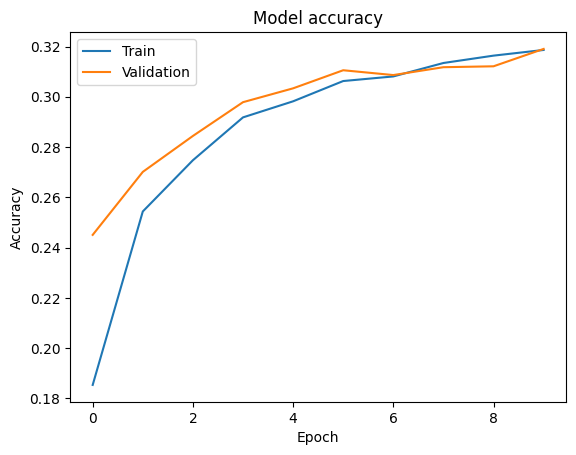

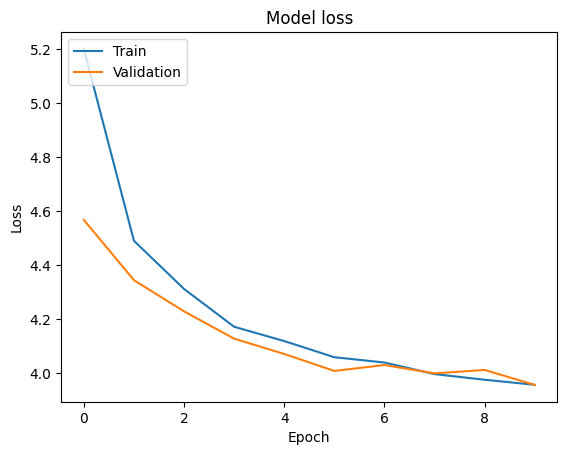

In [ ]:
plot_history(history_simple)

In [ ]:
def build_model(lstm_units=256, output_dim=128, dropout_rate=0.2, dense_units_output=128):
    context_input = Input(shape=(10,), dtype=tf.int32, name="context_input")
    context_embedding = Embedding(input_dim=context_tv.vocabulary_size(), output_dim=output_dim, mask_zero=False)(context_input)
    context_lstm = LSTM(lstm_units, return_sequences=True, return_state=True)
    context_lstm_out, context_state_h, context_state_c = context_lstm(context_embedding)
    context_lstm_out = Dropout(dropout_rate)(context_lstm_out)

    t9_input = Input(shape=(10,), dtype=tf.int32, name="t9_input")
    t9_embedding = Embedding(input_dim=input_t9_tv.vocabulary_size(), output_dim=output_dim, mask_zero=False)(t9_input)
    t9_lstm = LSTM(lstm_units, return_sequences=True, return_state=True)
    t9_lstm_out, t9_state_h, t9_state_c = t9_lstm(t9_embedding)
    t9_lstm_out = Dropout(dropout_rate)(t9_lstm_out)

    combined_state_h = Dense(lstm_units, activation='tanh')(Concatenate()([context_state_h, t9_state_h]))
    combined_state_c = Dense(lstm_units, activation='tanh')(Concatenate()([context_state_c, t9_state_c]))

    decoder_input = Input(shape=(10,), dtype=tf.int32, name="decoder_input")
    decoder_embedding = Embedding(input_dim=target_tv.vocabulary_size(), output_dim=output_dim, mask_zero=False)(decoder_input)
    decoder_lstm = LSTM(lstm_units, return_sequences=True, return_state=True)
    decoder_lstm_out, _, _ = decoder_lstm(decoder_embedding, initial_state=[combined_state_h, combined_state_c])
    decoder_lstm_out = Dropout(dropout_rate)(decoder_lstm_out)

    # Aligner les dimensions pour l'attention
    encoder_combined = Concatenate()([context_lstm_out, t9_lstm_out])  # (batch_size, 10, 2 * lstm_units)
    encoder_combined = Dense(lstm_units, activation='relu')(encoder_combined)  # Réduire à (batch_size, 10, lstm_units)
    attention = Attention()([decoder_lstm_out, encoder_combined])
    decoder_combined = Concatenate()([decoder_lstm_out, attention])

    dense = Dense(dense_units_output, activation='relu')(decoder_combined)
    dense = Dropout(dropout_rate)(dense)
    output = Dense(target_tv.vocabulary_size(), activation='softmax')(dense)

    model = Model(inputs=[context_input, t9_input, decoder_input], outputs=output)
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

In [ ]:
# Visualiser le modèle
model = build_model()
keras.utils.plot_model(model, show_shapes=True, show_layer_names=True, to_file='model.png')

In [ ]:
def build_hyper_model(hp):
    lstm_units = hp.Choice('lstm_units', [64, 128])  # Réduit de [64, 128, 256, 512]
    output_dim = hp.Choice('output_dim', [32, 64])   # Réduit de [32, 64, 128, 256]
    dropout_rate = hp.Float('dropout_rate', 0.0, 0.5, step=0.1)  # Limite à 0.5
    dense_units_output = hp.Choice('dense_units_output', [64, 128])
    return build_model(lstm_units, output_dim, dropout_rate, dense_units_output)

# Créer un objet tuner
tuner = keras_tuner.RandomSearch(
    build_hyper_model,
    objective='val_accuracy',
    max_trials=10,
    executions_per_trial=1,
    directory='hyperparameter_tuning',
    project_name='chinese_news_tuning'
)

early_stopping = keras.callbacks.EarlyStopping(
    monitor='val_accuracy',
    patience=3,
    restore_best_weights=True
)


# Réduire la taille des ensembles de données pour le tuning
ds_train_small = round(ds_train.cardinality().numpy()/4)
ds_val_small = round(ds_val.cardinality().numpy()/4)

tuner.search(
    ds_train.take(ds_train_small),
    epochs=15,
    validation_data=ds_val.take(ds_val_small),
    callbacks=[early_stopping]
)


# Obtenir le meilleur modèle
best_model = tuner.get_best_models(num_models=1)[0]

Reloading Tuner from hyperparameter_tuning/chinese_news_tuning/tuner0.json

Search: Running Trial #7

Value             |Best Value So Far |Hyperparameter
128               |128               |lstm_units
32                |64                |output_dim
0.2               |0.1               |dropout_rate
128               |128               |dense_units_output



Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x1076ba3c0>>
Traceback (most recent call last):
  File "/Users/petx/Desktop/Model_T9_to_Sinogram/tf_venv/lib/python3.12/site-packages/ipykernel/ipkernel.py", line 775, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(

KeyboardInterrupt: 


Epoch 1/15


2025-04-12 22:23:53.223219: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:14: Filling up shuffle buffer (this may take a while): 11829 of 23509
2025-04-12 22:24:02.559176: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:482] Shuffle buffer filled.


  49/3134 ━━━━━━━━━━━━━━━━━━━━ 4:39 91ms/step - accuracy: 0.0264 - loss: 8.1052

KeyboardInterrupt: 

In [ ]:
best_hyperparameters = tuner.get_best_hyperparameters()[0]
print("Best hyperparameters:")
print(f"lstm_units: {best_hyperparameters.get('lstm_units')}")
print(f"output_dim: {best_hyperparameters.get('output_dim')}")
print(f"dropout_rate: {best_hyperparameters.get('dropout_rate')}")
print(f"dense_units_output: {best_hyperparameters.get('dense_units_output')}")

Best hyperparameters:
lstm_units: 128
output_dim: 64
dropout_rate: 0.1
dense_units_output: 128


In [ ]:
model = build_model(
    lstm_units=best_hyperparameters.get('lstm_units'),
    output_dim=best_hyperparameters.get('output_dim'),
    dropout_rate=best_hyperparameters.get('dropout_rate'),
)


history = model.fit(
    ds_train.take(nb_train_samples),
    validation_data=ds_val.take(nb_val_samples),
    epochs=50,
    callbacks=[early_stopping],
    verbose=1
)

Epoch 1/50


2025-04-12 22:24:45.111634: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:14: Filling up shuffle buffer (this may take a while): 13076 of 23509
2025-04-12 22:24:53.099089: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:482] Shuffle buffer filled.


4702/4702 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - accuracy: 0.2519 - loss: 4.3641

2025-04-12 22:32:03.595973: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:14: Filling up shuffle buffer (this may take a while): 12721 of 23509
2025-04-12 22:32:11.989104: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:482] Shuffle buffer filled.


4702/4702 ━━━━━━━━━━━━━━━━━━━━ 485s 97ms/step - accuracy: 0.2519 - loss: 4.3638 - val_accuracy: 0.5689 - val_loss: 1.6002
Epoch 2/50


2025-04-12 22:32:42.410251: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:14: Filling up shuffle buffer (this may take a while): 12665 of 23509
2025-04-12 22:32:50.852366: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:482] Shuffle buffer filled.


4702/4702 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - accuracy: 0.5758 - loss: 1.5866

2025-04-12 22:39:59.318734: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:14: Filling up shuffle buffer (this may take a while): 12342 of 23509
2025-04-12 22:40:08.669011: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:482] Shuffle buffer filled.


4702/4702 ━━━━━━━━━━━━━━━━━━━━ 476s 97ms/step - accuracy: 0.5758 - loss: 1.5866 - val_accuracy: 0.6313 - val_loss: 1.3226
Epoch 3/50


2025-04-12 22:40:38.821604: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:14: Filling up shuffle buffer (this may take a while): 12289 of 23509
2025-04-12 22:40:47.543580: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:482] Shuffle buffer filled.


4702/4702 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - accuracy: 0.6260 - loss: 1.3782

2025-04-12 22:47:56.419265: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:14: Filling up shuffle buffer (this may take a while): 12383 of 23509
2025-04-12 22:48:05.644081: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:482] Shuffle buffer filled.


4702/4702 ━━━━━━━━━━━━━━━━━━━━ 477s 97ms/step - accuracy: 0.6260 - loss: 1.3782 - val_accuracy: 0.6543 - val_loss: 1.2410
Epoch 4/50


2025-04-12 22:48:35.923925: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:14: Filling up shuffle buffer (this may take a while): 12400 of 23509
2025-04-12 22:48:44.664555: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:482] Shuffle buffer filled.


4702/4702 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - accuracy: 0.6498 - loss: 1.2830

2025-04-12 22:55:53.366349: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:14: Filling up shuffle buffer (this may take a while): 12448 of 23509
2025-04-12 22:56:02.046627: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:482] Shuffle buffer filled.


4702/4702 ━━━━━━━━━━━━━━━━━━━━ 476s 97ms/step - accuracy: 0.6498 - loss: 1.2830 - val_accuracy: 0.6812 - val_loss: 1.1374
Epoch 5/50


2025-04-12 22:56:32.064840: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:14: Filling up shuffle buffer (this may take a while): 12346 of 23509
2025-04-12 22:56:40.827798: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:482] Shuffle buffer filled.


4702/4702 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - accuracy: 0.6618 - loss: 1.2428

2025-04-12 23:03:49.338433: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:14: Filling up shuffle buffer (this may take a while): 12025 of 23509
2025-04-12 23:03:58.621309: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:482] Shuffle buffer filled.


4702/4702 ━━━━━━━━━━━━━━━━━━━━ 477s 97ms/step - accuracy: 0.6618 - loss: 1.2428 - val_accuracy: 0.6854 - val_loss: 1.1355
Epoch 6/50


2025-04-12 23:04:28.747808: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:14: Filling up shuffle buffer (this may take a while): 12526 of 23509
2025-04-12 23:04:37.407674: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:482] Shuffle buffer filled.


4702/4702 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - accuracy: 0.6675 - loss: 1.2357

2025-04-12 23:11:47.656263: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:14: Filling up shuffle buffer (this may take a while): 12431 of 23509
2025-04-12 23:11:56.560650: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:482] Shuffle buffer filled.


4702/4702 ━━━━━━━━━━━━━━━━━━━━ 478s 98ms/step - accuracy: 0.6675 - loss: 1.2357 - val_accuracy: 0.6924 - val_loss: 1.1090
Epoch 7/50


2025-04-12 23:12:26.676772: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:14: Filling up shuffle buffer (this may take a while): 12495 of 23509
2025-04-12 23:12:35.304320: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:482] Shuffle buffer filled.


4702/4702 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - accuracy: 0.6741 - loss: 1.2149

2025-04-12 23:19:42.537096: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:14: Filling up shuffle buffer (this may take a while): 12230 of 23509
2025-04-12 23:19:51.676266: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:482] Shuffle buffer filled.


4702/4702 ━━━━━━━━━━━━━━━━━━━━ 475s 97ms/step - accuracy: 0.6741 - loss: 1.2149 - val_accuracy: 0.6982 - val_loss: 1.0903
Epoch 8/50


2025-04-12 23:20:21.891510: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:14: Filling up shuffle buffer (this may take a while): 12444 of 23509
2025-04-12 23:20:30.757460: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:482] Shuffle buffer filled.


4702/4702 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - accuracy: 0.6794 - loss: 1.1933

2025-04-12 23:27:39.888216: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:14: Filling up shuffle buffer (this may take a while): 12368 of 23509
2025-04-12 23:27:48.898738: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:482] Shuffle buffer filled.


4702/4702 ━━━━━━━━━━━━━━━━━━━━ 477s 97ms/step - accuracy: 0.6794 - loss: 1.1933 - val_accuracy: 0.7040 - val_loss: 1.0960
Epoch 9/50


2025-04-12 23:28:19.042824: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:14: Filling up shuffle buffer (this may take a while): 12342 of 23509
2025-04-12 23:28:27.826447: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:482] Shuffle buffer filled.


4702/4702 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - accuracy: 0.6837 - loss: 1.1928

2025-04-12 23:35:35.090302: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:14: Filling up shuffle buffer (this may take a while): 12334 of 23509
2025-04-12 23:35:44.058748: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:482] Shuffle buffer filled.


4702/4702 ━━━━━━━━━━━━━━━━━━━━ 475s 97ms/step - accuracy: 0.6837 - loss: 1.1928 - val_accuracy: 0.6953 - val_loss: 1.1327
Epoch 10/50


2025-04-12 23:36:14.202394: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:14: Filling up shuffle buffer (this may take a while): 12523 of 23509
2025-04-12 23:36:22.888752: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:482] Shuffle buffer filled.


4702/4702 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - accuracy: 0.6815 - loss: 1.2109

2025-04-12 23:43:31.003713: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:14: Filling up shuffle buffer (this may take a while): 12525 of 23509
2025-04-12 23:43:39.714471: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:482] Shuffle buffer filled.


4702/4702 ━━━━━━━━━━━━━━━━━━━━ 476s 97ms/step - accuracy: 0.6815 - loss: 1.2109 - val_accuracy: 0.6999 - val_loss: 1.1122
Epoch 11/50


2025-04-12 23:44:09.914797: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:14: Filling up shuffle buffer (this may take a while): 12395 of 23509
2025-04-12 23:44:18.775372: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:482] Shuffle buffer filled.


4702/4702 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - accuracy: 0.6821 - loss: 1.2175

2025-04-12 23:51:28.103490: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:14: Filling up shuffle buffer (this may take a while): 12319 of 23509
2025-04-12 23:51:36.946919: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:482] Shuffle buffer filled.


4702/4702 ━━━━━━━━━━━━━━━━━━━━ 477s 97ms/step - accuracy: 0.6821 - loss: 1.2175 - val_accuracy: 0.7000 - val_loss: 1.1162


In [ ]:
# sauvegarder le modèle
model.save('models/model.h5')

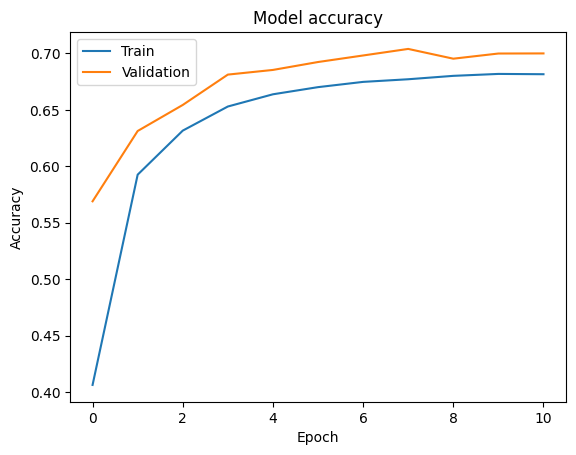

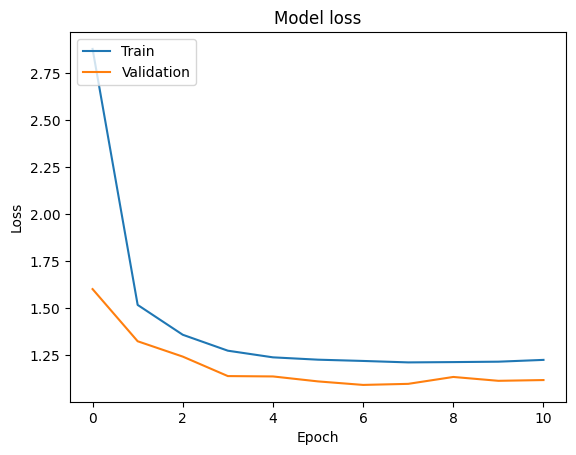

In [ ]:
plot_history(history)

In [ ]:
# Evaluer le modèle sur le jeu de test
test_loss, test_accuracy = model.evaluate(ds_test, verbose=1)
print(f"Test accuracy: {test_accuracy:.4f}")

2025-04-13 08:32:28.947481: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:14: Filling up shuffle buffer (this may take a while): 12399 of 23509
2025-04-13 08:32:37.944149: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:482] Shuffle buffer filled.


2350/2350 ━━━━━━━━━━━━━━━━━━━━ 102s 35ms/step - accuracy: 0.7019 - loss: 1.0998
Test accuracy: 0.7021


# Génération

In [ ]:
def generate_text(model, context_char_sequence, input_t9_sequence, char_vectorization, t9_vectorization, max_target_length=10):
    """
    Génère une séquence de caractères chinois à partir d'une séquence T9 et d'un contexte donné.

    Paramètres :
    - model : Le modèle Keras entraîné pour la prédiction T9 vers texte.
    - context_char_sequence : str, séquence de caractères chinois précédents (contexte).
    - input_t9_sequence : str, séquence de codes T9 séparés par des espaces.
    - char_vectorization : TextVectorization, couche de vectorisation pour les caractères chinois.
    - t9_vectorization : TextVectorization, couche de vectorisation pour les codes T9.
    - max_target_length : int, longueur maximale de la séquence cible à générer (par défaut 10).

    Retourne :
    - str, la séquence de caractères chinois prédite.
    """
    
    # Prétraitement des entrées
    if not context_char_sequence or not input_t9_sequence:
        return ""
    
    # Vectorisation du contexte et de la séquence T9
    context_vectorized = char_vectorization(tf.convert_to_tensor([context_char_sequence]))
    t9_vectorized = t9_vectorization(tf.convert_to_tensor([input_t9_sequence]))
    
    # Préparer les tenseurs d'entrée pour le modèle
    context_input = tf.expand_dims(context_vectorized, axis=0)  # Ajouter une dimension batch
    t9_input = tf.expand_dims(t9_vectorized, axis=0)           # Ajouter une dimension batch
    
    # Initialisation de la séquence cible prédite
    predicted_sequence = []
    current_sequence = ""  # Séquence en cours de construction
    
    # Génération caractère par caractère
    for _ in range(max_target_length):
        # Prédire le prochain caractère
        predictions = model.predict([context_input, t9_input], verbose=0)
        
        # Extraire l'indice du caractère le plus probable
        predicted_id = tf.argmax(predictions[0, len(predicted_sequence)], axis=-1).numpy()
        
        # Convertir l'identifiant en caractère via le vocabulaire inverse
        vocab = char_vectorization.get_vocabulary()
        if predicted_id < len(vocab):
            predicted_char = vocab[predicted_id]
        else:
            predicted_char = ""  # Caractère inconnu ou fin
        
        # Vérifier si le caractère est valide ou si c'est une fin de séquence
        if predicted_char in ["", "[UNK]"]:  # [UNK] pour caractère inconnu
            break
        
        # Ajouter le caractère prédit à la séquence
        predicted_sequence.append(predicted_char)
        current_sequence += predicted_char
        
        # Mettre à jour le contexte pour la prochaine itération
        new_context = context_char_sequence + current_sequence
        context_input = tf.expand_dims(char_vectorization([new_context]), axis=0)
    
    # Retourner la séquence prédite sous forme de chaîne
    return "".join(predicted_sequence)

In [ ]:
context = "中国"
t9_input = "736 646 543"
result = generate_text(model, context, t9_input, char_vectorization, t9_vectorization)
print(f"Texte généré : {result}")